In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# === Preprocessing: sharpening and histogram equalization ===
def preprocess_image(image):
    # Xử lý ảnh có 4 kênh (BGRA)
    if image.shape[2] == 4:
        gray = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp = cv2.filter2D(eq, -1, kernel)
    return cv2.cvtColor(sharp, cv2.COLOR_GRAY2BGR)

# === Utility: Rotate with options for transparency or interpolation fill ===
def rotate_bound(image, angle, mode="inpaint"):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = abs(M[0, 0]); sin = abs(M[0, 1])
    nW = int((h * sin) + (w * cos)); nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX; M[1, 2] += (nH / 2) - cY

    if mode == "transparent":
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
        rotated = cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
        return rotated, M

    elif mode == "interpolate":
        return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT), M

    else:
        return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)), M

def inpaint_borders(rotated):
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    mask = (gray == 0).astype(np.uint8) * 255
    return cv2.inpaint(rotated, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

def rotate_and_fill(image, angle, mode="inpaint"):
    rot, M = rotate_bound(image, angle, mode)
    if mode == "inpaint":
        rot = inpaint_borders(rot)
    return rot, M

# === Improved skew detection using Hough Transform ===
def detect_skew_hough(gray, delta=1, limit=45, visualize=False):
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)
    edges = cv2.Canny(thresh, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    hough_vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    if lines is not None:
        angles = [line[0][1] for line in lines]
        for line in lines:
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            if visualize:
                cv2.line(hough_vis, (x1, y1), (x2, y2), (0, 255, 0), 1)

        median_angle = np.median(angles)
        skew_deg = np.rad2deg(median_angle) - 90
        return (skew_deg, hough_vis) if visualize else skew_deg
    else:
        return (0, hough_vis) if visualize else 0

# === Skew detection using PCA on contours ===
def detect_skew_pca(gray):
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0
    cnt = max(contours, key=cv2.contourArea)
    data_pts = np.array(cnt, dtype=np.float64).reshape(-1, 2)
    mean, eigenvectors = cv2.PCACompute(data_pts, mean=None)
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    return np.rad2deg(angle)

# === Combine skew detection methods ===
def detect_skew_combined(gray, visualize=False):
    hough_angle, hough_vis = detect_skew_hough(gray, visualize=visualize)
    pca_angle = detect_skew_pca(gray)
    angle = np.median([hough_angle, pca_angle])
    return (angle, hough_vis) if visualize else angle

# === Improved skew detection using Hough Transform with visualization ===
def detect_skew_angle(gray, delta=1, limit=45, visualize=False):
    # Adaptive threshold for structure enhancement
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)

    # Hough Line detection for orientation
    edges = cv2.Canny(thresh, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

    hough_vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    if lines is not None:
        angles = [line[0][1] for line in lines]  # Fixed unpacking error
        for line in lines:
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            if visualize:
                cv2.line(hough_vis, (x1, y1), (x2, y2), (0, 255, 0), 1)

        median_angle = np.median(angles)
        skew_deg = np.rad2deg(median_angle) - 90
        return (skew_deg, hough_vis) if visualize else skew_deg
    else:
        angles = np.arange(-limit, limit + delta, delta)
        scores = []
        for angle in angles:
            M = cv2.getRotationMatrix2D((gray.shape[1] // 2, gray.shape[0] // 2), angle, 1.0)
            rotated = cv2.warpAffine(gray, M, (gray.shape[1], gray.shape[0]), flags=cv2.INTER_CUBIC)
            hist = cv2.reduce(rotated, 1, cv2.REDUCE_AVG).flatten()
            score = np.sum((hist[1:] - hist[:-1]) ** 2)
            scores.append(score)
        best_angle = angles[np.argmax(scores)]
        return (best_angle, hough_vis) if visualize else best_angle

# === Method: Manual Deskew ===
def deskew_manual(image, delta=1, limit=45, mode="inpaint", visualize=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    angle_info = detect_skew_combined(gray, visualize=visualize)
    if visualize:
        angle, lines_img = angle_info
    else:
        angle = angle_info
        lines_img = None
    rotated, M = rotate_and_fill(image, angle, mode)
    return rotated, angle, M, lines_img

# === Feature Matcher: switchable among SIFT, ORB, AKAZE ===
def create_feature_detector(method="SIFT"):
    """
    Create a feature detector and return both detector and matcher.
    method: str, one of {"SIFT", "ORB", "AKAZE"}
    """
    method = method.upper()
    if method == "SIFT":
        detector = cv2.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2)
    elif method == "ORB":
        detector = cv2.ORB_create(nfeatures=1000)
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    elif method == "AKAZE":
        detector = cv2.AKAZE_create()
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    else:
        raise ValueError("Unsupported method: choose from 'SIFT', 'ORB', 'AKAZE'")
    return detector, matcher

In [3]:
# === Match template using feature extraction and visualize points ===
def match_template_features(template, target, method="SIFT"):
    """
    Perform feature-based template matching using SIFT keypoints, visualize keypoints, matching pairs,
    and generate a heatmap over the target image.

    Parameters:
    - template: Template image to locate
    - target: Image where template is searched

    Returns:
    - result_img: Target image with bounding box, keypoints, and heatmap
    - vis: Side-by-side image showing feature matching between template and target
    """
    template = preprocess_image(template)
    target = preprocess_image(target)

    detector, matcher = create_feature_detector(method)
    kp1, des1 = detector.detectAndCompute(template, None)
    kp2, des2 = detector.detectAndCompute(target, None)

    if des1 is None or des2 is None:
        print("No descriptors found in one of the images.")
        return target, None

    # Apply Lowe's ratio test
    good_matches = []
    if method.upper() == "SIFT":
        # Use knnMatch + ratio test for SIFT
        # FLANN matcher for descriptor matching
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
    else:
        # Use simple match for ORB/AKAZE
        matches = matcher.match(des1, des2)
        good_matches = sorted(matches, key=lambda x: x.distance)[:50]

    result = target.copy()
    heatmap = np.zeros(target.shape[:2], dtype=np.float32)

    if len(good_matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

        # Populate heatmap
        for pt in dst_pts:
            x, y = int(pt[0]), int(pt[1])
            if 0 <= y < heatmap.shape[0] and 0 <= x < heatmap.shape[1]:
                heatmap[y, x] += 1

        # Normalize and convert heatmap to color
        heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(result, 0.7, heatmap_color, 0.3, 0)

        # Estimate homography and transform template corners
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if H is not None:
            h, w = template.shape[:2]
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
            projected = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), H)
            cv2.polylines(overlay, [np.int32(projected)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Draw matched keypoints
        for pt in dst_pts:
            cv2.circle(overlay, tuple(np.int32(pt)), 3, (255, 255, 255), -1)

        # Draw keypoint matching visualization
        vis = cv2.drawMatches(template, kp1, target, kp2, good_matches, None, flags=2)

        return overlay, vis
    else:
        print("Not enough good matches found.")
        vis = cv2.drawMatches(template, kp1, target, kp2, good_matches, None, flags=2)
        return result, vis
    

def match_multi_templates(templates, target):
    """
    Perform template matching using improved SDF logic:
    - Normalized Cross-Correlation
    - Multi-scale Template Search
    - Heatmap overlay and bounding box visualization
    """
    target_gray = cv2.cvtColor(preprocess_image(target), cv2.COLOR_BGR2GRAY)
    sdf_maps = []
    match_locs = []

    for tmpl in templates:
        tmpl_gray = cv2.cvtColor(preprocess_image(tmpl), cv2.COLOR_BGR2GRAY)
        best_response = None
        best_loc = None
        best_size = None
        best_heatmap = None

        for scale in [0.8, 1.0, 1.2]:
            resized_tmpl = cv2.resize(tmpl_gray, (0, 0), fx=scale, fy=scale)
            response = cv2.matchTemplate(target_gray, resized_tmpl, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(response)

            if best_response is None or max_val > best_response:
                best_response = max_val
                best_loc = max_loc
                best_size = resized_tmpl.shape[::-1]  # (width, height)
                best_heatmap = response

        # Resize heatmap to match original target shape for consistent stacking
        heatmap_resized = cv2.resize(best_heatmap, (target_gray.shape[1], target_gray.shape[0]))
        sdf_maps.append(heatmap_resized)
        match_locs.append((best_loc, best_size))

    # Stack and visualize
    best_map = np.max(np.stack(sdf_maps), axis=0)
    heatmap = cv2.normalize(best_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    color_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay
    overlay = cv2.cvtColor(target_gray, cv2.COLOR_GRAY2BGR)
    result = cv2.addWeighted(overlay, 0.7, color_heatmap, 0.3, 0)

    for pt, size in match_locs:
        cv2.rectangle(result, pt, (pt[0] + size[0], pt[1] + size[1]), (255, 255, 255), 2)
        cv2.drawMarker(result, (pt[0] + size[0] // 2, pt[1] + size[1] // 2), (0, 0, 255), cv2.MARKER_CROSS, 20, 2)

    return result, color_heatmap

# === Combined Template Matching: Feature + SDF ===
def match_multi_templates_features(templates, target, method="SIFT"):
    target_proc = preprocess_image(target)
    target_gray = cv2.cvtColor(target_proc, cv2.COLOR_BGR2GRAY)
    combined_heatmap = np.zeros_like(target_gray, dtype=np.float32)
    overlay = target_proc.copy()

    for tmpl in templates:
        tmpl_proc = preprocess_image(tmpl)
        tmpl_gray = cv2.cvtColor(tmpl_proc, cv2.COLOR_BGR2GRAY)

        # Feature matching
        detector, matcher = create_feature_detector(method)
        kp1, des1 = detector.detectAndCompute(tmpl_proc, None)
        kp2, des2 = detector.detectAndCompute(target_proc, None)

        if des1 is not None and des2 is not None:
            if method.upper() == "SIFT":
                index_params = dict(algorithm=1, trees=5)
                search_params = dict(checks=50)
                flann = cv2.FlannBasedMatcher(index_params, search_params)
                matches = flann.knnMatch(des1, des2, k=2)
                good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
            else:
                matches = matcher.match(des1, des2)
                good_matches = sorted(matches, key=lambda x: x.distance)[:50]

            if len(good_matches) >= 4:
                dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
                for pt in dst_pts:
                    x, y = int(pt[0]), int(pt[1])
                    if 0 <= y < combined_heatmap.shape[0] and 0 <= x < combined_heatmap.shape[1]:
                        combined_heatmap[y, x] += 1

        # SDF-like template matching
        for scale in [0.8, 1.0, 1.2]:
            resized_tmpl = cv2.resize(tmpl_gray, (0, 0), fx=scale, fy=scale)
            response = cv2.matchTemplate(target_gray, resized_tmpl, cv2.TM_CCOEFF_NORMED)
            response_resized = cv2.resize(response, (target_gray.shape[1], target_gray.shape[0]))
            combined_heatmap += response_resized

    heatmap_norm = cv2.normalize(combined_heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    color_heatmap = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
    result = cv2.addWeighted(overlay, 0.7, color_heatmap, 0.3, 0)
    return result, color_heatmap


In [4]:
# === Example Usage in Jupyter ===
img = cv2.imread('images/bo du lieu bia so 4/bia4 (3).bmp')           # Load input image
template = cv2.imread('images/templates/bia4.png')                      # Load template image


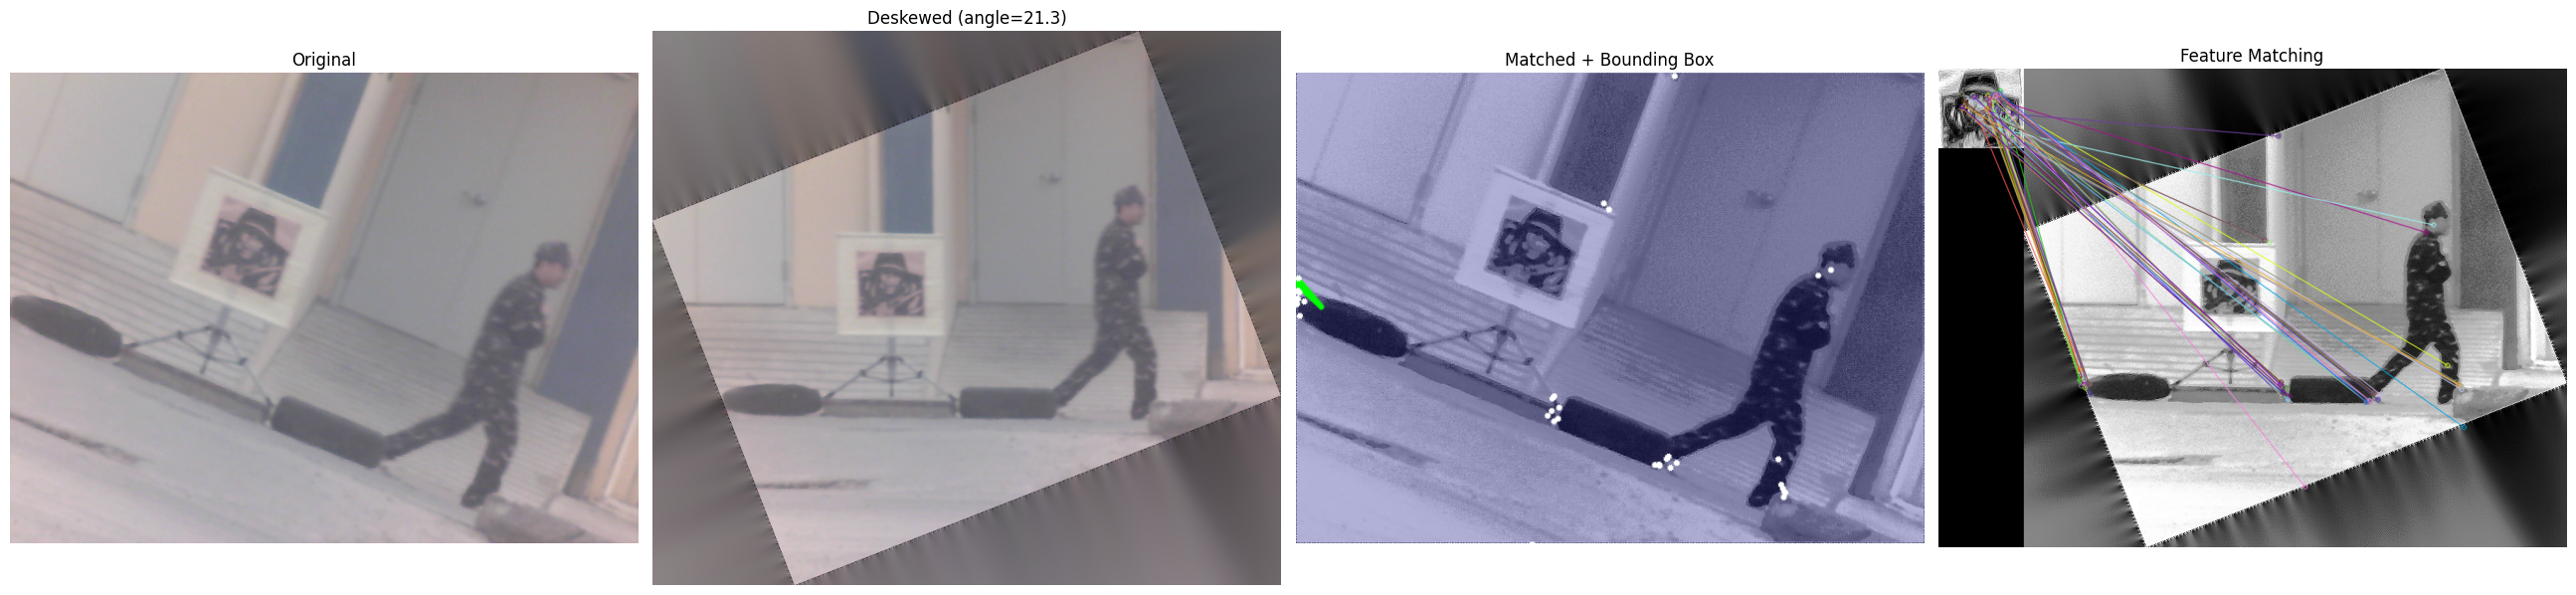

In [5]:
# Step 1: Deskew image
result = deskew_manual(img, mode="inpaint", visualize=True)
deskewed, angle, M, lines_img = result

# Step 2: Match template using SIFT features
matched_img, vis_match = match_template_features(template, deskewed, method='ORB')

# Step 3: Rotate matched image back to original orientation
inv_M = cv2.invertAffineTransform(M)
restored = cv2.warpAffine(matched_img, inv_M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# Step 4: Show results
fig, ax = plt.subplots(1, 4, figsize=(26,6))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(deskewed, cv2.COLOR_BGR2RGB)); ax[1].set_title(f"Deskewed (angle={angle:.1f})"); ax[1].axis('off')
ax[2].imshow(cv2.cvtColor(restored, cv2.COLOR_BGR2RGB)); ax[2].set_title("Matched + Bounding Box"); ax[2].axis('off')
ax[3].imshow(cv2.cvtColor(vis_match, cv2.COLOR_BGR2RGB) if vis_match is not None else np.zeros_like(img)); ax[3].set_title("Feature Matching"); ax[3].axis('off')
plt.tight_layout(); plt.show()

In [6]:
# === Example Usage in Jupyter ===
img = cv2.imread('images/bo du lieu bia so 4/bia4 (1).bmp')           # Load input image
templates = [cv2.imread('images/templates/bia4.png'), cv2.imread('images/templates/bia4_00.png'), cv2.imread('images/templates/bia4_01.png')]  # Multiple templates

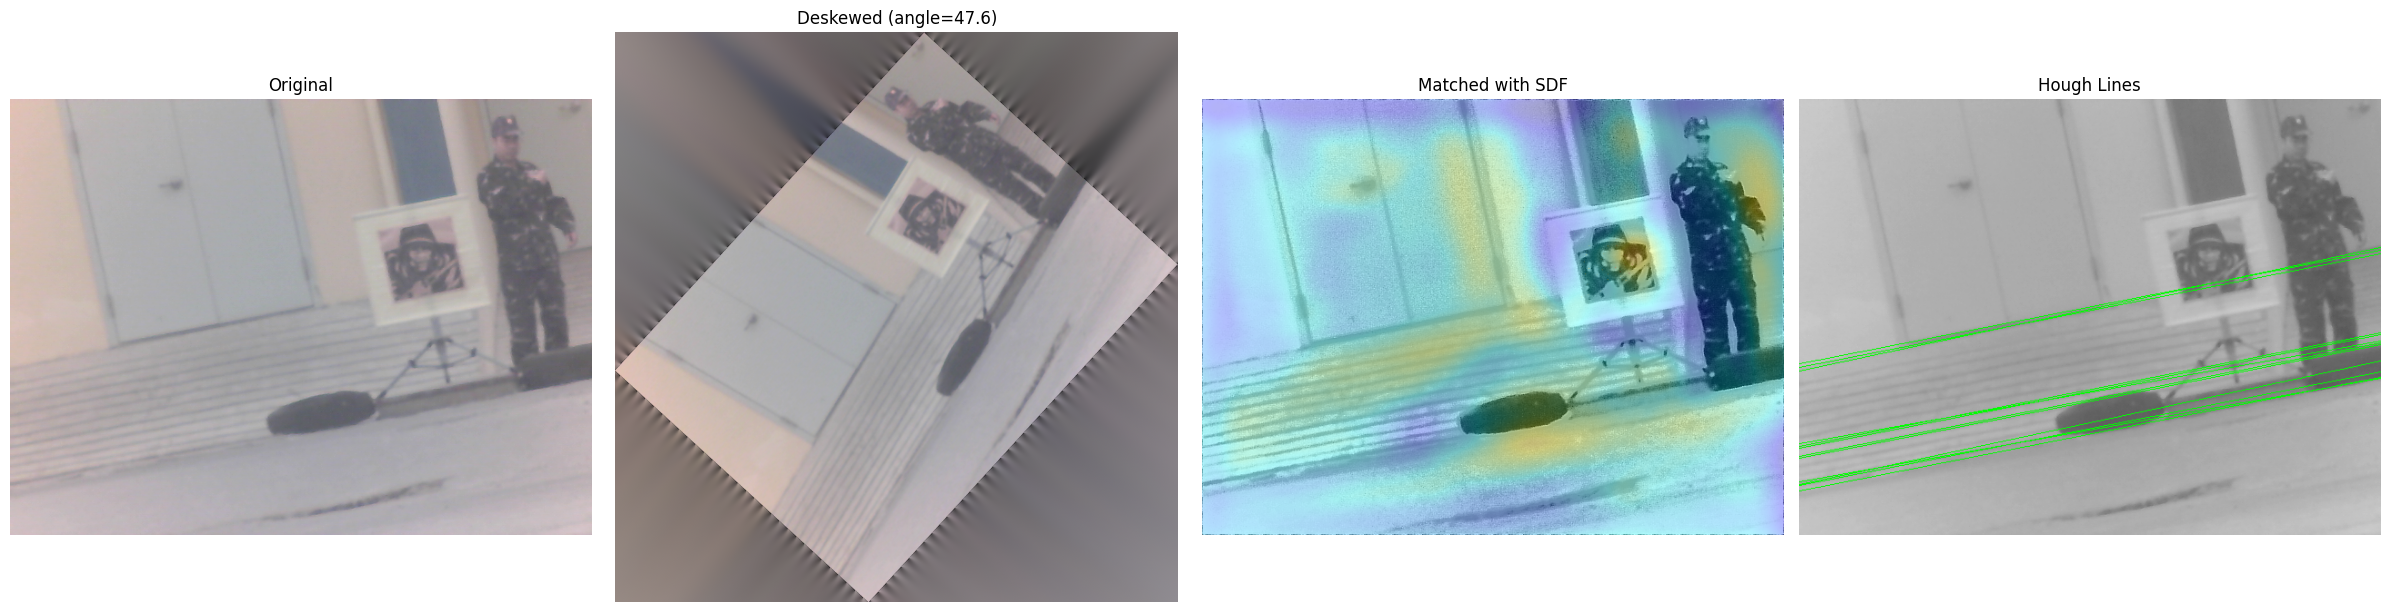

In [7]:
# Step 1: Deskew image
result = deskew_manual(img, mode="inpaint", visualize=True)
deskewed, angle, M, lines_img = result

# # Step 2: Match template using SDF (option 1)
# matched_img, heatmap = match_multi_templates(templates, deskewed)
# Step 2: Match template using combine (option 2)
matched_img, heatmap = match_multi_templates_features(templates, deskewed)

# Step 3: Rotate matched image back to original orientation
inv_M = cv2.invertAffineTransform(M)
restored = cv2.warpAffine(matched_img, inv_M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# Step 4: Show results
fig, ax = plt.subplots(1, 4, figsize=(24,6))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(deskewed, cv2.COLOR_BGR2RGB)); ax[1].set_title(f"Deskewed (angle={angle:.1f})"); ax[1].axis('off')
ax[2].imshow(cv2.cvtColor(restored, cv2.COLOR_BGR2RGB)); ax[2].set_title("Matched with SDF"); ax[2].axis('off')
ax[3].imshow(cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)); ax[3].set_title("Hough Lines"); ax[3].axis('off')
plt.tight_layout(); plt.show()